In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import cross_val_score


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

## Load Houseprices Dataset

In [57]:
# connect to Thinkful database to load houseprices dataset
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# close connection
engine.dispose()

# check first 5 rows
houseprices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


## Data Cleaning

In [58]:
# create new columns to indicate presence of a feature
houseprices['has_pool'] = np.where(houseprices['poolqc'].notnull(), 1, 0)
houseprices['has_miscfeature'] = np.where(houseprices['miscfeature'].notnull(), 1, 0)
houseprices['has_alley'] = np.where(houseprices['alley'].notnull(), 1, 0)
houseprices['has_fence'] = np.where(houseprices['fence'].notnull(), 1, 0)
houseprices['has_fireplace'] = np.where(houseprices['fireplacequ'].notnull(), 1, 0)
houseprices['has_garage'] = np.where(houseprices['garagecond'].notnull(), 1, 0)
houseprices['has_bsmt'] = np.where(houseprices['bsmtexposure'].notnull(), 1, 0)

#drop original column from dataframe
houseprices.drop(['poolqc','miscfeature','alley','fence','fireplacequ'], axis=1, inplace=True)

# replace missing values with 0 for lot frontage, garageyrblt, and masvnrarea
houseprices['lotfrontage'].fillna(0, inplace=True)
houseprices['garageyrblt'].fillna(0, inplace=True)
houseprices['masvnrarea'].fillna(0, inplace=True)

# replace missing values with "None" for categorical garage and basement features
fill_list = ['garagecond','garagetype','garagefinish','garagequal','bsmtexposure','bsmtfintype2',
            'bsmtfintype1','bsmtcond','bsmtqual','masvnrtype']

houseprices[fill_list].replace({np.nan:'None'}, inplace=True)
    
# replace missing electrical values with most common value
houseprices['electrical'].fillna(houseprices['electrical'].mode()[0], inplace=True)

In [59]:
houseprices['totalsf'] = houseprices['totalbsmtsf'] + houseprices['firstflrsf'] + houseprices['secondflrsf']

houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.mszoning, prefix="mszoning", drop_first=True)], axis=1)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices.neighborhood, prefix="nh", drop_first=True)], axis=1)
dummy_col = list(pd.get_dummies(houseprices.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_col = dummy_col + list(pd.get_dummies(houseprices.neighborhood, prefix="nh", drop_first=True).columns)

In [60]:
houseprices.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,nh_NoRidge,nh_NridgHt,nh_OldTown,nh_SWISU,nh_Sawyer,nh_SawyerW,nh_Somerst,nh_StoneBr,nh_Timber,nh_Veenker
0,1,60,RL,65.000,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,0,0,0,0,0
1,2,20,RL,80.000,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,0,0,0,1
2,3,60,RL,68.000,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,0,0,0,0,0
3,4,70,RL,60.000,9550,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,0,0,0,0,0
4,5,60,RL,84.000,14260,Pave,IR1,Lvl,AllPub,FR2,...,1,0,0,0,0,0,0,0,0,0


In [61]:
houseprices.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,nh_NoRidge,nh_NridgHt,nh_OldTown,nh_SWISU,nh_Sawyer,nh_SawyerW,nh_Somerst,nh_StoneBr,nh_Timber,nh_Veenker
count,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,...,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000,1460.000
mean,730.500,56.897,57.623,10516.828,6.099,5.575,1971.268,1984.866,103.117,443.640,...,0.028,0.053,0.077,0.017,0.051,0.040,0.059,0.017,0.026,0.008
std,421.610,42.301,34.664,9981.265,1.383,1.113,30.203,20.645,180.731,456.098,...,0.165,0.224,0.267,0.130,0.219,0.197,0.236,0.130,0.159,0.087
min,1.000,20.000,0.000,1300.000,1.000,1.000,1872.000,1950.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,365.750,20.000,42.000,7553.500,5.000,5.000,1954.000,1967.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,730.500,50.000,63.000,9478.500,6.000,5.000,1973.000,1994.000,0.000,383.500,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,1095.250,70.000,79.000,11601.500,7.000,6.000,2000.000,2004.000,164.250,712.250,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,1460.000,190.000,313.000,215245.000,10.000,9.000,2010.000,2010.000,1600.000,5644.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


## Decision Tree

In [62]:
# select features
X = houseprices[['overallqual', 'totalsf', 'fullbath']]
# select target variable
y = houseprices.saleprice

In [63]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

In [66]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  

from sklearn import tree

# A convenience for displaying visualizations.
from IPython.display import Image

# Packages for rendering our tree.
import pydotplus
import graphviz

# create a regressor object 
decision_tree = DecisionTreeRegressor(
    criterion='mse',
    max_features=3,
    max_depth=4,
    random_state = 1337)
  
# fit the regressor with X and Y data 
decision_tree.fit(X_train, y_train) 

# test set
y_preds_test = decision_tree.predict(X_test)

print(cross_val_score(decision_tree, X, Y, cv=5))

import time
start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

[0.75784961 0.60653511 0.79323988 0.7582279  0.74130376]
--- 6.890296936035156e-05 seconds ---


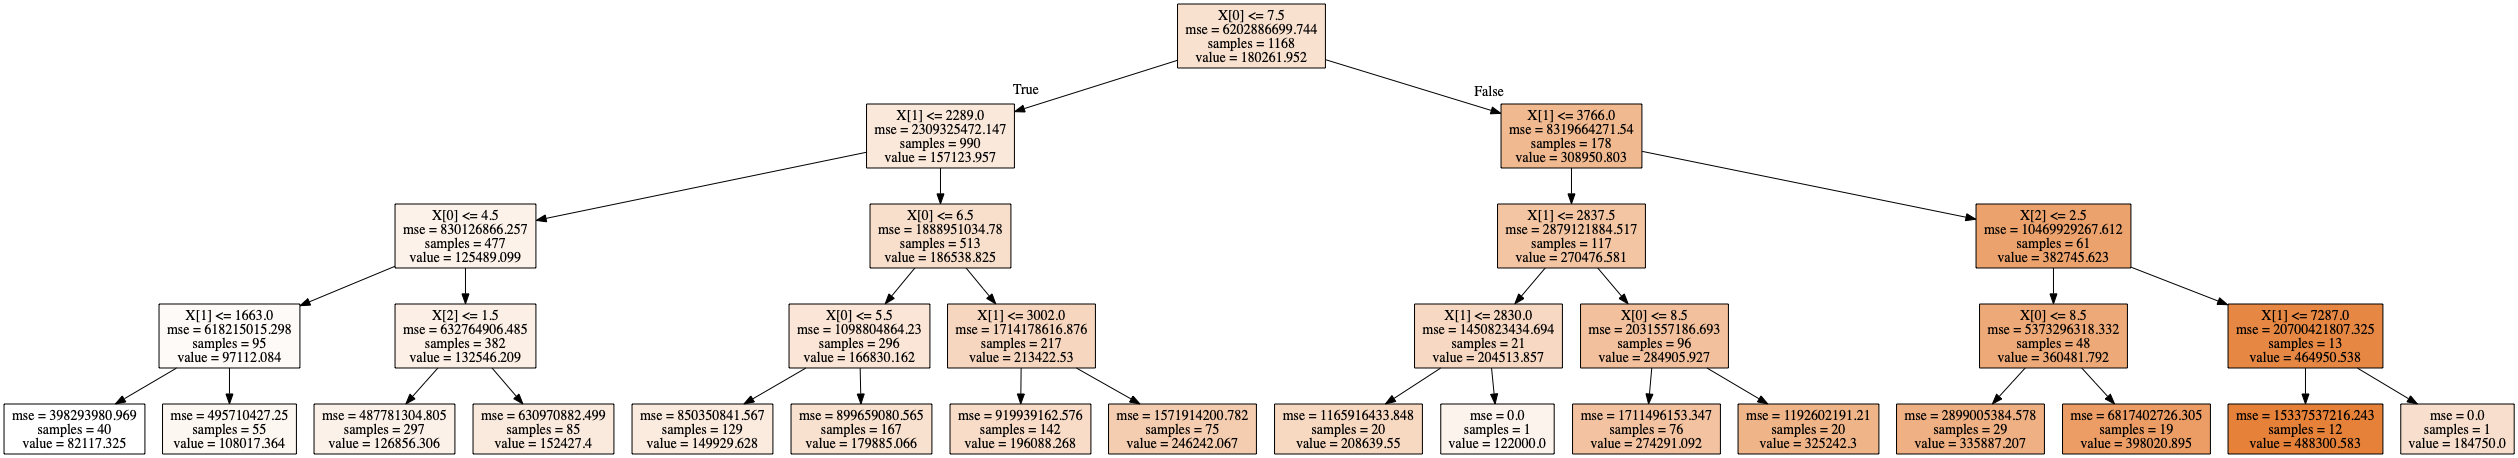

In [67]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=None,
    class_names=y_train,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [ ]:
score = decision_tree.score(X_test, y_test)
print(score)

## Random Forest

In [68]:
# select features
X = houseprices[['overallqual', 'grlivarea', 'garagecars', 'totalsf', 'fullbath'] + dummy_col]
# select target variable
Y = houseprices.saleprice

from sklearn import ensemble
from sklearn.model_selection import cross_val_score

random_forest = ensemble.RandomForestRegressor()

# fit model with X & Y values
random_forest.fit(X_train, y_train)

# test set
y_preds_test = decision_tree.predict(X_test)

print(cross_val_score(random_forest, X, Y, cv=5))

start_time = time.time()
print("--- %s seconds ---" % (time.time() - start_time))

[0.84383584 0.73000505 0.87167139 0.8629779  0.84156082]
--- 3.695487976074219e-05 seconds ---


In [69]:
score = rfc.score(X_test, y_test)
print(score)

0.8265916332343568
